# Assignment Summary

**Denoising autoencoders**: We will evaluate denoising autoencoders applied to the MNIST dataset.

* Obtain (or write! but this isn't required) a pytorch/tensorflow/etc. code for a denoising autoencoder. Train this autoencoder on the MNIST dataset. Use only the MNIST training set. You should use at least three layers in the encoder and in the decoder.
* We now need to determine how well this autoencoder works. For each image in the MNIST test dataset, compute the residual error of the autoencoder. This is the difference between the true image and the reconstruction of that image by the autoencoder. It is an image itself. Prepare a figure showing the mean residual error, and the first five principal components. Each is an image. You should preserve signs (i.e. the mean residual error may have negative as well as positive entries). The way to show these images most informatively is to use a mid gray value for zero, then darker values for more negative image values and lighter values for more positive values. The scale you choose matters. You should show
    * mean and five principal components on the same gray scale for all six images, chosen so the largest absolute value over all six images is full dark or full light respectively and
    * mean and five principal components on a scale where the gray scale is chosen for each image separately.

**Variational autoencoders**: We will evaluate variational autoencoders applied to the MNIST dataset.
  * Obtain (or write! but this isn't required) a pytorch/tensorflow/etc. code for a variational autoencoder. Train this autoencoder on the MNIST dataset. Use only the MNIST training set.
  * We now need to determine how well the codes produced by this autoencoder can be interpolated.
    * For 10 pairs of MNIST test images of the same digit, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.
    * For 10 pairs of MNIST test images of different digits, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.

**Hints and References**: For the denoising autoencoder, there is an abundance of code online should you choose to obtain one. It may be a good practice to also implement this part from scratch and test what you learned in the CNN assignment. All you have to do is define a network with two groups of layers:
  * *Encoder Layers*: This part must take an image and produce a low-dimensional "code" of the image. Therefore, the architecture of the netwok must be narrowing down. Let's call this function $f^{\text{encoder}}$.
  * *Decoder Layers*: This part must take a low-dimensional "code" of the image and produce the original image. Therefore, the architecture of the netwok must be expanding. Let's call this function $f^{\text{decoder}}$.
  
All you have to do is to try and write some code to minimize the following loss:

$$\mathcal{L} = \frac{1}{N} \sum_{i=1}^N \|x_i - f^{\text{decoder}}(f^{\text{encoder}}(x_i))\|_2^2$$

You may pick any architecture that works as long as it has three layes. The MNIST data has 784 pixels. Therefore, a fully connected network which takes 784 reshaped dimensions to $h_1$ dimensions, then to $h_2$ dimensions, and finally to $h_3$ dimensions is an excellent starting point for an encoder. A vast range of choices can work for these three numbers, but just to give you an idea about their plausible range of values, $h_1$ could be in the order of hundreds, $h_2$ could be in order of tens (or at most a few hundreds), and $h_3$ is supposed to be a low-dimension (preferrably under 10 or at most 20).

You can reverse the encoder architecture, to obtain a decoder, and then stack an SGD optimizer on top with default hyper-parameters to train your denoising autoencoder. You must be familiar with the rest of the concepts from earlier assignments such as multi-dimensional scalings and PCA. You also would need to write some basic code to visualize using matplotlib, PIL, etc.

For VAEs, you may also be able to implement everything from scratch once you review the material. However, there are a lot of resources and examples for implementing VAEs, and here we share a few of them:

  1. Pytorch Tutorials has an example for training VAEs at https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py
  2. Another pytorch example for VAEs can be found at https://github.com/pytorch/examples/blob/master/vae/main.py
  3. Pyro is a library for bayesian optimization and is based on pytorch, which has a detailed tutorial on how to train VAEs with some high-level story of the math involved https://pyro.ai/examples/vae.html
  4. BoTorch is another bayesian optimization library based based on pytorch and has some tutorials for implementing VAEs https://botorch.org/tutorials/vae_mnist
  5. If you're a tensorflow fan, you may find some tutorial at https://www.tensorflow.org/probability/examples/Probabilistic_Layers_VAE or  https://www.tensorflow.org/tutorials/generative/cvae
  6. Keras fans can also see https://keras.io/examples/generative/vae/
  7. etc.
  
The MNIST data is provided at `../VAE-lib/data_mnist` so that you could use the `torchvision` API for loading the data just like the previous assignment.

**Important Note**: This assignment will not be automatically graded and is optional. Therefore, do not expect meaninful grades to be published upon or after submission. However, please make sure to submit your work if you expect it to be reviewed by the instructors for any reason. We will consider the latest submission of your work. 

Any work that is not submitted will not be viewed by us.

In [1]:
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
import numpy as np
import torch
import botorch
import pyro
import matplotlib.pyplot as plt

In [2]:
# Additional import
import torch.utils.data
from torch import nn, optim
from torch.autograd import Variable
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import pandas as pd

# Reference
https://stackoverflow.com/questions/51735001/how-to-include-batch-size-in-pytorch-basic-example

In [3]:
# Configuration change
CUDA = False
SEED = 1
BATCH_SIZE = 128
LOG_INTERVAL = 10
EPOCHS = 10
ZDIMS = 20
kwargs = {'num_workers': 1, 'pin_memory': True} if CUDA else {}

In [ ]:
import osfrom torchvision import datasets, transformsfrom torch.utils.data import DataLoader# Ensure the dataset directory exists or set download flagdata_dir = '../VAE-lib/data_mnist'download_ = not os.path.exists(data_dir)# Define transformstransform = transforms.ToTensor()# Load the MNIST dataset using torchvision API with DataLoadertrain_dataset = datasets.MNIST(data_dir, train=True, transform=transform, download=download_)test_dataset = datasets.MNIST(data_dir, train=False, transform=transform, download=download_)# Create DataLoaders for batching and shufflingBATCH_SIZE = 64  # Example batch size, adjust as neededtrain_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [ ]:
# print(download_)

In [4]:
# Download or load downloaded MNIST dataset
# shuffle data at every epoch
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

# Reference: 
https://discuss.pytorch.org/t/loading-mnist-from-pytorch/137456/5

In [5]:
train_loader

In [6]:
# # Test data
test_data=datasets.MNIST('data', train=False, transform=transforms.ToTensor())
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=BATCH_SIZE, shuffle=True, **kwargs)

In [7]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

# Denoising Requirement
> - You should use at least three layers in the encoder and in the decoder.

In [8]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.relu = nn.ReLU()
        self.fc21 = nn.Linear(400, ZDIMS)  # mu layer
        self.fc22 = nn.Linear(400, ZDIMS)  # logvariance layer
        self.fc3 = nn.Linear(ZDIMS, 400)
        # from hidden 400 to 784 outputs
        self.fc4 = nn.Linear(400, 784)
        self.sigmoid = nn.Sigmoid()

    def encode(self, x: Variable) -> (Variable, Variable):

        h1 = self.relu(self.fc1(x))  # type: Variable
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu: Variable, logvar: Variable) -> Variable:

        if self.training:

            std = logvar.mul(0.5).exp_()  # type: Variable

            eps = Variable(std.data.new(std.size()).normal_())
            return eps.mul(std).add_(mu)

        else:

            return mu

    def decode(self, z: Variable) -> Variable:
        h3 = self.relu(self.fc3(z))
        return self.sigmoid(self.fc4(h3))

    def forward(self, x: Variable) -> (Variable, Variable, Variable):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [9]:
model = VAE()

In [10]:
print(model)

VAE(
  (fc1): Linear(in_features=784, out_features=400, bias=True)
  (relu): ReLU()
  (fc21): Linear(in_features=400, out_features=20, bias=True)
  (fc22): Linear(in_features=400, out_features=20, bias=True)
  (fc3): Linear(in_features=20, out_features=400, bias=True)
  (fc4): Linear(in_features=400, out_features=784, bias=True)
  (sigmoid): Sigmoid()
)


# Requirement: Loss and Loss Optimization

# Reference
https://stackoverflow.com/questions/67075117/variational-autoencoder-vae-returns-consistent-output

In [11]:
def loss_function(recon_x, x, mu, logvar) -> Variable:
    # how well do input x and output recon_x agree?
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784))

    # KLD is Kullback–Leibler divergence -- how much does one learned distribution deviate from another, in this specific case the learned distribution from the unit Gaussian
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    # Normalise by same number of elements as in reconstruction
    KLD /= BATCH_SIZE * 784

    # BCE tries to make our reconstruction as accurate as possible
    # KLD tries to push the distributions as close as possible to unit Gaussian
    return BCE + KLD

# Reference from the links

# Adam Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [12]:
def train(epoch):
    # Train 
    model.train()
    train_loss = 0
    # in the case of MNIST, len(train_loader.dataset) is 60000
    # each `data` is of BATCH_SIZE samples and has shape [128, 1, 28, 28]
    for batch_idx, (data, _) in enumerate(train_loader):
        data = Variable(data)
        if CUDA:
            data = data.cuda()
        optimizer.zero_grad()

        # push whole batch of data through VAE.forward() to get recon_loss
        recon_batch, mu, logvar = model(data)
        # calculate scalar loss
        loss = loss_function(recon_batch, data, mu, logvar)
        # calculate the gradient of the loss w.r.t. the graph leaves
        # i.e. input variables 
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)))

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))

In [13]:
def test(epoch):
    # Test
    model.eval()
    test_loss = 0

    # each data is of BATCH_SIZE (default 128) samples
    for i, (data, _) in enumerate(test_loader):
        if CUDA:
            #  on the GPU
            data = data.cuda()

        data = Variable(data, volatile=True)
        recon_batch, mu, logvar = model(data)
        test_loss += loss_function(recon_batch, data, mu, logvar).item()
        if i == 0:
          n = min(data.size(0), 8)
          # for the first 128 batch of the epoch, show the first 8 input digits
          # with right below them the reconstructed output digits
          comparison = torch.cat([data[:n],
                                  recon_batch.view(BATCH_SIZE, 1, 28, 28)[:n]])
          save_image(comparison.data.cpu(),
                      str(epoch) + '.png', nrow=n)

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

# Encoder Requirement : Residuals calculation

In [14]:
# Residuals
def compute_residual_error(model, test_loader):
    """
    Compute the residual error for each image in the MNIST test dataset.
    """
    model.eval()  # Set the model to evaluation mode
    residual_errors = []

    with torch.no_grad():  # No need to compute gradients
        for data, _ in test_loader:
            data = data.view(-1, 784)  # Flatten the image into a vector
            if CUDA:
                data = data.cuda()

            recon_data, _, _ = model(data)  # Reconstructed data
            residual_error = ((data - recon_data) ** 2).mean(dim=1).cpu().numpy()  # Mean squared error
            residual_errors.extend(residual_error)
    
    print("Average residual error for test dataset: {:.6f}".format(np.mean(residual_errors)))
    return residual_errors

In [15]:
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

    # 64 sets of random ZDIMS-float vectors, i.e. 64 locations / MNIST
    # digits in latent space
    sample = Variable(torch.randn(64, ZDIMS))
    print(sample.shape)
    if CUDA:
        sample = sample.cuda()
    sample = model.decode(sample).cpu()

    # save out as an 8x8 matrix of MNIST digits
    # this will give you a visual idea of how well latent space can generate things
    # that look like digits
    save_image(sample.data.view(64, 1, 28, 28),
                str(epoch) + '.png')

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.005490
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.003049
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.002353
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.002153
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.002125
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.002087
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.002061
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.001979
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.001950
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.001891
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001723
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.001741
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.001780
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.001721
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.001684
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.001625
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.001652
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.001624
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.001609
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.001524
Train Epoch: 1 [

In [ ]:
# Test set Loss : 0.0011

In [16]:
# Call Residuals
for epoch in range(1, EPOCHS + 1):
    train(epoch)
    test(epoch)

# Call the residual error computation after training/testing epochs are complete
residual_errors = compute_residual_error(model, test_loader)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.001036
Train Epoch: 1 [1280/60000 (2%)]	Loss: 0.001057
Train Epoch: 1 [2560/60000 (4%)]	Loss: 0.001041
Train Epoch: 1 [3840/60000 (6%)]	Loss: 0.001037
Train Epoch: 1 [5120/60000 (9%)]	Loss: 0.001044
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.001079
Train Epoch: 1 [7680/60000 (13%)]	Loss: 0.001084
Train Epoch: 1 [8960/60000 (15%)]	Loss: 0.001038
Train Epoch: 1 [10240/60000 (17%)]	Loss: 0.001044
Train Epoch: 1 [11520/60000 (19%)]	Loss: 0.001034
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.001074
Train Epoch: 1 [14080/60000 (23%)]	Loss: 0.001018
Train Epoch: 1 [15360/60000 (26%)]	Loss: 0.001095
Train Epoch: 1 [16640/60000 (28%)]	Loss: 0.001058
Train Epoch: 1 [17920/60000 (30%)]	Loss: 0.001071
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.001114
Train Epoch: 1 [20480/60000 (34%)]	Loss: 0.001045
Train Epoch: 1 [21760/60000 (36%)]	Loss: 0.001024
Train Epoch: 1 [23040/60000 (38%)]	Loss: 0.001098
Train Epoch: 1 [24320/60000 (41%)]	Loss: 0.001053
Train Epoch: 1 [

In [ ]:
# Average Loss:0.008826

In [17]:
# Compute Mean residual error image
def compute_mean_residual_image(model, test_loader):
    model.eval()
    residual_images = []

    with torch.no_grad():
        for data, _ in test_loader:
            data = data.view(-1, 784)  # Flatten to vector
            if CUDA:
                data = data.cuda()

            recon_data, _, _ = model(data)
            residual = (data - recon_data).cpu().numpy()
            residual_images.extend(residual)

    residual_images = np.array(residual_images)
    mean_residual_image = residual_images.mean(axis=0).reshape(28, 28)  # Reshape to 28x28
    return mean_residual_image, residual_images

In [19]:
# Perform PCA
from sklearn.decomposition import PCA

def compute_principal_components(residual_images, n_components=5):
    pca = PCA(n_components=n_components)
    residual_flat = residual_images.reshape(residual_images.shape[0], -1)  # Flatten to 784
    principal_components = pca.fit_transform(residual_flat)  # Apply PCA
    components_reshaped = [pca.components_[i].reshape(28, 28) for i in range(n_components)]
    return components_reshaped

In [20]:
# Visualize Images with Gray Scale
def plot_images(mean_image, components, common_scale=True):
    """
    Plot the mean residual image and principal components on a gray scale.
    """
    images = [mean_image] + components
    num_images = len(images)
    
    # Determine the gray scale range
    if common_scale:
        max_abs = max(abs(img).max() for img in images)  # Largest absolute value across all images
        vmin, vmax = -max_abs, max_abs
    else:
        vmin, vmax = None, None  # Matplotlib automatically determines scale for each image
    
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    for i, ax in enumerate(axes):
        ax.imshow(images[i], cmap='gray', vmin=vmin, vmax=vmax)
        ax.axis('off')
        ax.set_title('Mean' if i == 0 else f'PC {i}')
    plt.show()

# Denoising Images
> - mean and five principal components on the same gray scale for all six images, chosen so the largest absolute value over all six images is full dark or full light respectively
> - mean and five principal components on a scale where the gray scale is chosen for each image separately.

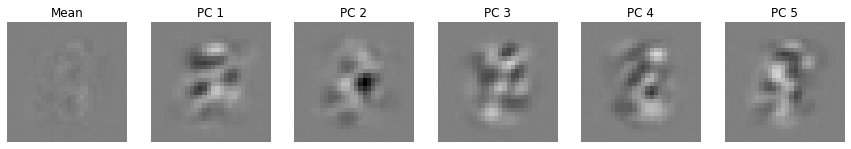

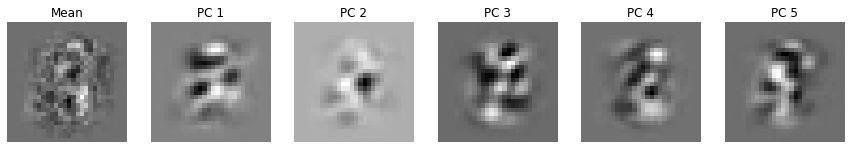

In [21]:
# Compute mean residual image
mean_residual_image, residual_images = compute_mean_residual_image(model, test_loader)

# Compute first five principal components
components = compute_principal_components(residual_images, n_components=5)

# Plot images with common scale
plot_images(mean_residual_image, components, common_scale=True)

# Plot images with individual scale
plot_images(mean_residual_image, components, common_scale=False)

# Variational autoencoders - Question 1
> For 10 pairs of MNIST test images of the same digit, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.

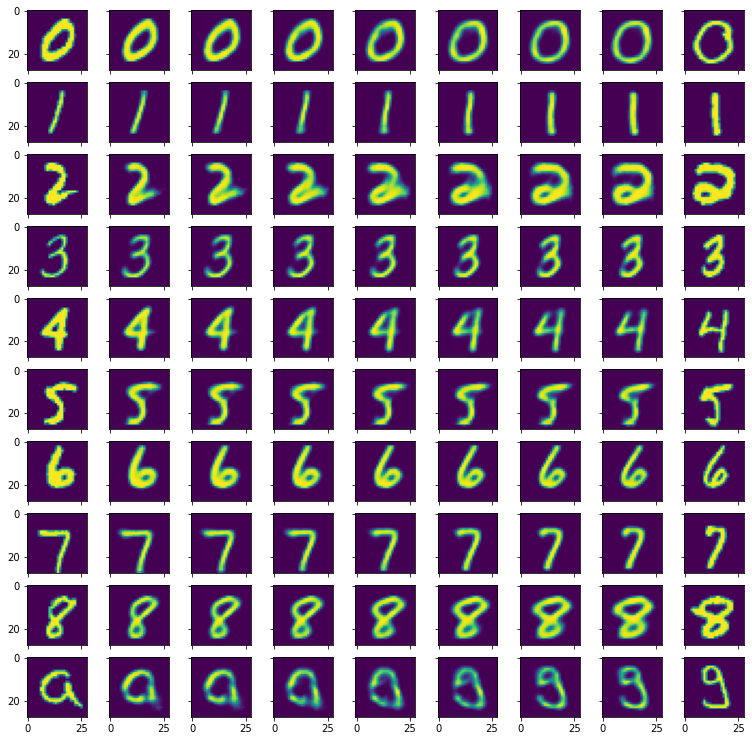

In [22]:
# import matplotlib.pyplot as plt
# import numpy as np
labels=np.arange(10)
fig, axes = plt.subplots(nrows=10, ncols=9, sharex=True, sharey=True,figsize=(13,13))

for label in labels:
  idx = test_data.targets==label
  idx=(idx != 0).nonzero().view(-1)
  loader = torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=False, sampler=torch.utils.data.SubsetRandomSampler(idx),**kwargs)
  data,_=next(iter(loader))
  image_1=data[0].reshape((28,28))
  image_2=data[1].reshape((28,28))
  axes[label,0].imshow(image_1)
  axes[label,8].imshow(image_2)
  data=Variable(data)
  _,mu, logvar=model.forward(data)
  mu=mu.detach().numpy()
  var=logvar.detach().numpy()
  inter_num=7
  interpolation_mu=np.zeros((inter_num,20))
  interpolation_var=np.zeros((inter_num,20))
  for i in range(20):
      mu_spaced=np.linspace(mu[0,i],mu[1,i],num=inter_num,endpoint=False)
      var_spaced=np.linspace(var[0,i],var[1,i],num=inter_num,endpoint=False)
      interpolation_mu[:,i]=mu_spaced
      interpolation_var[:,i]=var_spaced
  interpolation_var=Variable(torch.tensor(interpolation_var))
  interpolation_mu=Variable(torch.tensor(interpolation_mu))
  z = model.reparameterize(interpolation_mu, interpolation_var)
  z=Variable(torch.tensor(z).float())
  sample=model.decode(z).cpu()
  sample=sample.detach().numpy()
  for i in range(inter_num):
    image=sample[i].reshape((28,28))
    axes[label,i+1].imshow(image)
plt.show()

# Variational Encoders - Question 2
> For 10 pairs of MNIST test images of different digits, selected at random, compute the code for each image of the pair. Now compute 7 evenly spaced linear interpolates between these codes, and decode the result into images. Prepare a figure showing this interpolate. Lay out the figure so each interpolate is a row. On the left of the row is the first test image; then the interpolate closest to it; etc; to the last test image. You should have a 10 rows and 9 columns of images.

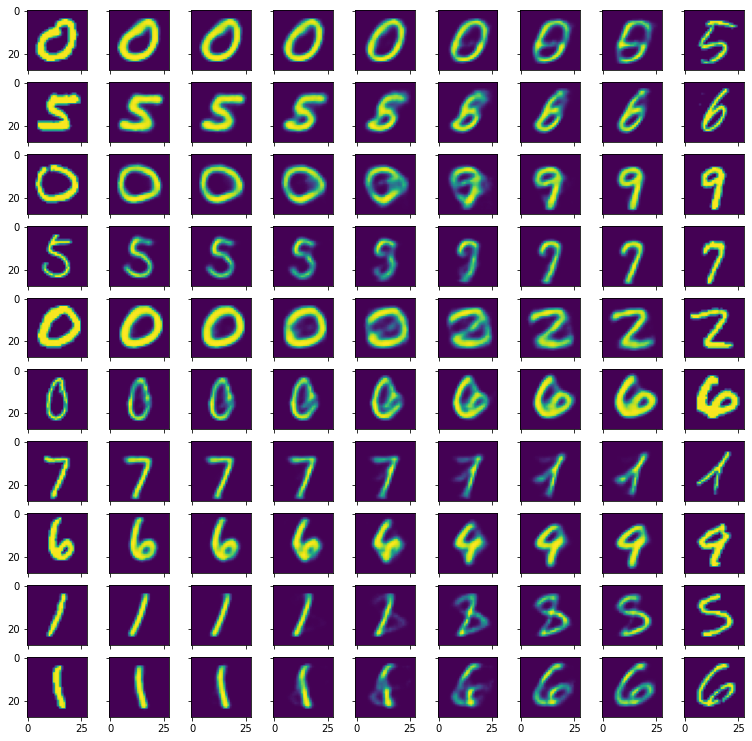

In [23]:
fig, axes = plt.subplots(nrows=10, ncols=9, sharex=True, sharey=True,figsize=(13,13))
k=0
while k<10:
  loader = torch.utils.data.DataLoader(test_data, batch_size=2, shuffle=True,**kwargs)
  data,labels=next(iter(loader))
  if labels[0]==labels[1]:
    continue
  image_1=data[0].reshape((28,28))
  image_2=data[1].reshape((28,28))
  axes[k,0].imshow(image_1)
  axes[k,8].imshow(image_2)
  data=Variable(data)
  _,mu, logvar=model.forward(data)
  mu=mu.detach().numpy()
  var=logvar.detach().numpy()
  inter_num=7
  interpolation_mu=np.zeros((inter_num,20))
  interpolation_var=np.zeros((inter_num,20))
  for i in range(20):
      mu_spaced=np.linspace(mu[0,i],mu[1,i],num=inter_num,endpoint=False)
      var_spaced=np.linspace(var[0,i],var[1,i],num=inter_num,endpoint=False)
      interpolation_mu[:,i]=mu_spaced
      interpolation_var[:,i]=var_spaced
  interpolation_var=Variable(torch.tensor(interpolation_var))
  interpolation_mu=Variable(torch.tensor(interpolation_mu))
  z = model.reparameterize(interpolation_mu, interpolation_var)
  z=Variable(torch.tensor(z).float())
  sample=model.decode(z).cpu()
  sample=sample.detach().numpy()
  for j in range(inter_num):
    image=sample[j].reshape((28,28))
    axes[k,j+1].imshow(image)
  k+=1
plt.show()

# References
## Below  links used as reference for assignment
1. https://www.kaggle.com/code/fazilbtopal/variantional-autoencoders-vae
2. https://medium.com/@sofeikov/implementing-variational-autoencoders-from-scratch-533782d8eb95
3. https://medium.com/@noufalsamsudin/latent-space-interpolation-of-images-using-keras-and-tensorflow-js-7e35bec01c5a

# The end